# DCF Valuation Walk-through (1997-2002)

This notebook demonstrates the process of creating a Discounted Cash Flow (DCF) valuation from a 5-year revenue forecast.

We will use the custom `ValuationDCF` and `Financials` classes, calling the methods sequentially to show how the valuation is built from the ground up.

## 1. Imports

First, we import our external libraries and, most importantly, our custom `Financials`, `ValuationDCF`, and `IOService` classes from their respective `.py` files.

In [1]:
import pandas as pd
import polars as pl
import numpy as np
from datetime import datetime
from loguru import logger
from pathlib import Path

from valuation.analysis.financials import Financials
from valuation.analysis.valuation import ValuationDCF, ValuationAssumptions
from valuation.infra.file.io.stable import IOService
from valuation.infra.loggers import configure_logging
from valuation.analysis.valuation import REPORT_DIRECTORY

configure_logging()


## 2. Setup: Load Financial Assumptions and Base Financials (1997)

The valuation process requires a base year of financial data. We'll instantiate the `Financials` class, which loads the 1997 data by default and automatically calculates key ratios.

In [2]:
assumptions = ValuationAssumptions()
print(assumptions)
base_financials = Financials()

print(f"Base Financials Loaded for Fiscal Year: {base_financials.fiscal_year}")
print(f"Base Revenue: ${base_financials.revenue:,.0f}")
print(f"Calculated Operating Margin: {base_financials.operating_margin:.2f}%")
print(f"Calculated CapEx as % of Sales: {base_financials.capex_to_sales:.2f}%")
print(80*"=")
print(base_financials.income_statement)
print(base_financials.balance_sheet)
print(base_financials.cashflow_statement)
print(80*"=")
print(base_financials.profitability_ratios)
print(80*"=")
print(base_financials.profitability_metrics)
print(80*"=")
print(base_financials.efficiency_ratios)






                      ValuationAssumptions                      
                  risk_free_rate | 0.06
             market_risk_premium | 0.05
                            beta | 0.60
            terminal_growth_rate | 0.03
           terminal_fcf_multiple | 12
               minority_interest | 0.00
               other_adjustments | 0.00
                            wacc | 0.09


Base Financials Loaded for Fiscal Year: 1997
Base Revenue: $2,511,962,000
Calculated Operating Margin: 0.03%
Calculated CapEx as % of Sales: -1.97%


                        IncomeStatement                         
                         revenue | 2,511,962,000
                            cogs | 1,932,994,000
                             sga | 491,359,000
                    gross_profit | 578,968,000
                operating_income | 77,109,000
                interest_expense | 67,555,000
           earnings_before_taxes | 6,813,000
              income_tax_expense | 7,385,000
                      ne

## 3. Setup: Load 5-Year Forecast (1998-2002)

Next, we load the 5-year revenue forecast generated by our `mlforecast` model.

In [ ]:
# --- Load the Forecast Data --- 
forecast_filepath =  "report/forecasts_5year_1997_20022025-10-25_Oct-10-1761433429.csv"
forecast_col_name = 'LGBMRegressor/MinTrace_method-ols' # This is the reconciled column

try:
    # Obtain the hierarchical forecast dataframe
    hierarchical_forecast_df = IOService.read(forecast_filepath)
    # Convert to pandas
    if isinstance(hierarchical_forecast_df, pl.LazyFrame):
        hierarchical_forecast_df = hierarchical_forecast_df.collect().to_pandas()
    elif isinstance(hierarchical_forecast_df, pl.DataFrame):
        hierarchical_forecast_df = hierarchical_forecast_df.to_pandas()
    forecast_df = hierarchical_forecast_df.copy()        
    
    # Ensure 'ds' column is datetime
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
    
    print(f"Successfully loaded forecast from {forecast_filepath}")
    print(f"Total rows: {len(forecast_df):,}")
    print(f"Date Range: {forecast_df['ds'].min().date()} to {forecast_df['ds'].max().date()}")
    print(f"Forecast column to be used: {forecast_col_name}")
    print(f"Unique series found: {forecast_df['unique_id'].nunique():,}")
    print("\n--- Forecast Head ---")
    print(forecast_df.head())
except Exception as e:
    print(f"Error loading forecast file: {e}")
    print("Please ensure 'forecasts_5year_1997_2002.csv' is in the same directory as this notebook.")
    forecast_df = None # Set to None to prevent downstream errors

Successfully loaded forecast from report/forecasts_5year_1997_20022025-10-25_Oct-10-1761433429.csv
Total rows: 603,460
Date Range: 1997-01-01 to 2001-12-19
Forecast column to be used: LGBMRegressor/MinTrace_method-ols
Unique series found: 2,321

--- Forecast Head ---
            unique_id         ds  LGBMRegressor  \
30680  100/analgesics 1997-01-01    2017.331576   
30681  100/analgesics 1997-01-08    1973.758208   
30682  100/analgesics 1997-01-15    1844.060599   
30683  100/analgesics 1997-01-22    1857.610458   
30684  100/analgesics 1997-01-29    1781.994691   

       LGBMRegressor/MinTrace_method-ols  
30680                        2017.331576  
30681                        1973.758208  
30682                        1844.060599  
30683                        1857.610458  
30684                        1781.994691  


## 4. Setup: Initialize `ValuationDCF` Class

With our `base_financials` and `forecast_df` ready, we can now initialize the `ValuationDCF` class. This class will hold all our assumptions and calculated data.

In [4]:
# Set valuation parameters
valuation_date = pd.Timestamp('1997-01-01')

# Initialize the DCF class
if forecast_df is not None:
    dcf = ValuationDCF(
        financials=base_financials,
        assumptions=assumptions,
        forecast_df=forecast_df,
        forecast_col=forecast_col_name,
        valuation_date=valuation_date,
    )
else:
    print("\n🛑 DCF Class not initialized because forecast data failed to load.")
    dcf = None

DCF VALUATION INITIALIZED
Valuation Date: 1997-01-01
Forecast Column: LGBMRegressor/MinTrace_method-ols
WACC: 9.00%


## 5. The Valuation Process: Step-by-Step

Instead of calling `run_full_valuation()`, we will call each method individually to walk through the logic. The `loguru` logger will print detailed output at each stage.

### Step 1: Aggregate Weekly Revenue

In [5]:
if dcf:
    dcf.aggregate_revenue()

AGGREGATING TO TOTAL COMPANY REVENUE
Total company weekly revenue forecasts: 260 weeks
Average weekly revenue: $5,512,459
Total 5-year revenue: $1,433,239,406


### Step 2: Convert to Annual Revenue

Now that `dcf.company_revenue_weekly` is populated, the rest of the methods will work correctly. This step converts the weekly totals into the 5 annual figures needed for the DCF.

In [6]:
if dcf:
    dcf.convert_to_annual()

CONVERTING TO ANNUAL REVENUE
Annual Revenue Forecasts:
  1997: 285,571,208
  1998: 286,339,116
  1999: 291,233,652
  2000: 290,062,135
  2001: 280,033,295


### Step 3: Build DCF Model (Calculate FCF)

This is the core of the model. The class takes the annual revenue, applies the operating assumptions from `financials` (OpMargin, CapEx, NWC), and calculates the Free Cash Flow (FCF) for each of the 5 years. It then discounts these FCFs to their present value (PV).

In [7]:
if dcf:
    dcf.build_dcf_model() # type: ignore

BUILDING DCF MODEL


,year,years_from_val,revenue,ebit,nopat,capex,nwc_change,fcf,discount_factor,pv_fcf
0,"1,997",0.5,"$285,571,208","$8,766,100","$5,697,965","$5,637,388",0.0,"$60,577",0.9578,"$58,022"
1,"1,998",1.5,"$286,339,116","$8,789,672","$5,713,287","$5,652,547",0.0,"$60,740",0.8787,"$53,374"
2,"1,999",2.5,"$291,233,652","$8,939,919","$5,810,947","$5,749,169",0.0,"$61,778",0.8062,"$49,804"
3,"2,000",3.5,"$290,062,135","$8,903,957","$5,787,572","$5,726,042",-0.0,"$61,529",0.7396,"$45,508"
4,"2,001",4.5,"$280,033,295","$8,596,104","$5,587,468","$5,528,066",-0.0,"$59,402",0.6785,"$40,307"


DCF Model - Annual Projections:

 year  years_from_val      revenue         ebit        nopat        capex  nwc_change          fcf  discount_factor       pv_fcf
 1997             0.5 2.855712e+08 8.766100e+06 5.697965e+06 5.637388e+06         0.0 60576.799376         0.957826 58022.050717
 1998             1.5 2.863391e+08 8.789672e+06 5.713287e+06 5.652547e+06         0.0 60739.691884         0.878740 53374.379305
 1999             2.5 2.912337e+08 8.939919e+06 5.810947e+06 5.749169e+06         0.0 61777.945527         0.806183 49804.343130
 2000             3.5 2.900621e+08 8.903957e+06 5.787572e+06 5.726042e+06        -0.0 61529.437421         0.739618 45508.256940
 2001             4.5 2.800333e+08 8.596104e+06 5.587468e+06 5.528066e+06        -0.0 59402.069520         0.678548 40307.172592


### Step 4: Calculate Terminal Value

After the 5-year forecast period, we calculate the terminal value using the perpetuity growth model. This value represents the sum of all future cash flows beyond Year 5, discounted back to Year 5, and then discounted back to the present.

In [8]:
if dcf:
    dcf.calculate_terminal_value()

CALCULATING TERMINAL VALUE
Terminal Year (2001) FCF: $59,402

Method 1 - Perpetuity Growth:
  Terminal Value: $1,019,736
  PV of Terminal Value: $691,940

Method 2 - Exit Multiple (12x):
  Terminal Value: $712,825
  PV: $483,686


### Step 5: Calculate Enterprise Value

Enterprise Value (EV) is the sum of the Present Value of the 5-year forecast FCFs and the Present Value of the Terminal Value.

In [9]:
if dcf:
    dcf.calculate_enterprise_value()

CALCULATING ENTERPRISE VALUE
PV of Forecast Period FCFs: $247,016
PV of Terminal Value: $691,940
ENTERPRISE VALUE: $938,956

Value Composition:
  Forecast Period: 26.3%
  Terminal Value: 73.7%


### Step 6: Bridge to Equity Value

Finally, we bridge from Enterprise Value to Equity Value by subtracting Net Debt and any other adjustments.

In [10]:
if dcf:
    dcf.calculate_equity_value()

BRIDGING TO EQUITY VALUE
Enterprise Value: $938,956
Less: Net Debt: $507,965,000
Less: Minority Interest: $0
Plus/Less: Other Adjustments: $0
EQUITY VALUE: $-507,026,044


## 6. Post-Calculation: Analysis and Outputs

With the valuation complete, we can run the sensitivity analysis and generate our final reports.

### Step 7: Run Sensitivity Analysis

This method creates a 2-way data table showing how Enterprise Value changes based on different WACC and Terminal Growth Rate assumptions.

In [11]:
if dcf:
    dcf.run_sensitivity_analysis()

RUNNING SENSITIVITY ANALYSIS
Enterprise Value Sensitivity (in $ millions):
Rows: Terminal Growth Rate | Columns: WACC

wacc             0.070  0.075  0.080  0.085  0.090  0.095  0.100  0.105  0.110
terminal_growth                                                               
0.020             1.15   1.05   0.97   0.90   0.83   0.78   0.74   0.69   0.66
0.025             1.26   1.13   1.04   0.95   0.88   0.82   0.77   0.72   0.68
0.030             1.39   1.24   1.12   1.02   0.94   0.87   0.81   0.76   0.72
0.035             1.55   1.37   1.22   1.10   1.01   0.93   0.86   0.80   0.75
0.040             1.78   1.53   1.34   1.20   1.09   0.99   0.91   0.85   0.79


### Step 8: Create Visualizations

This method generates the 9-panel dashboard and saves it as a `.png` file in our working directory.

CREATING VISUALIZATIONS
Dashboard saved to: report/dcf_valuation_dashboard.png


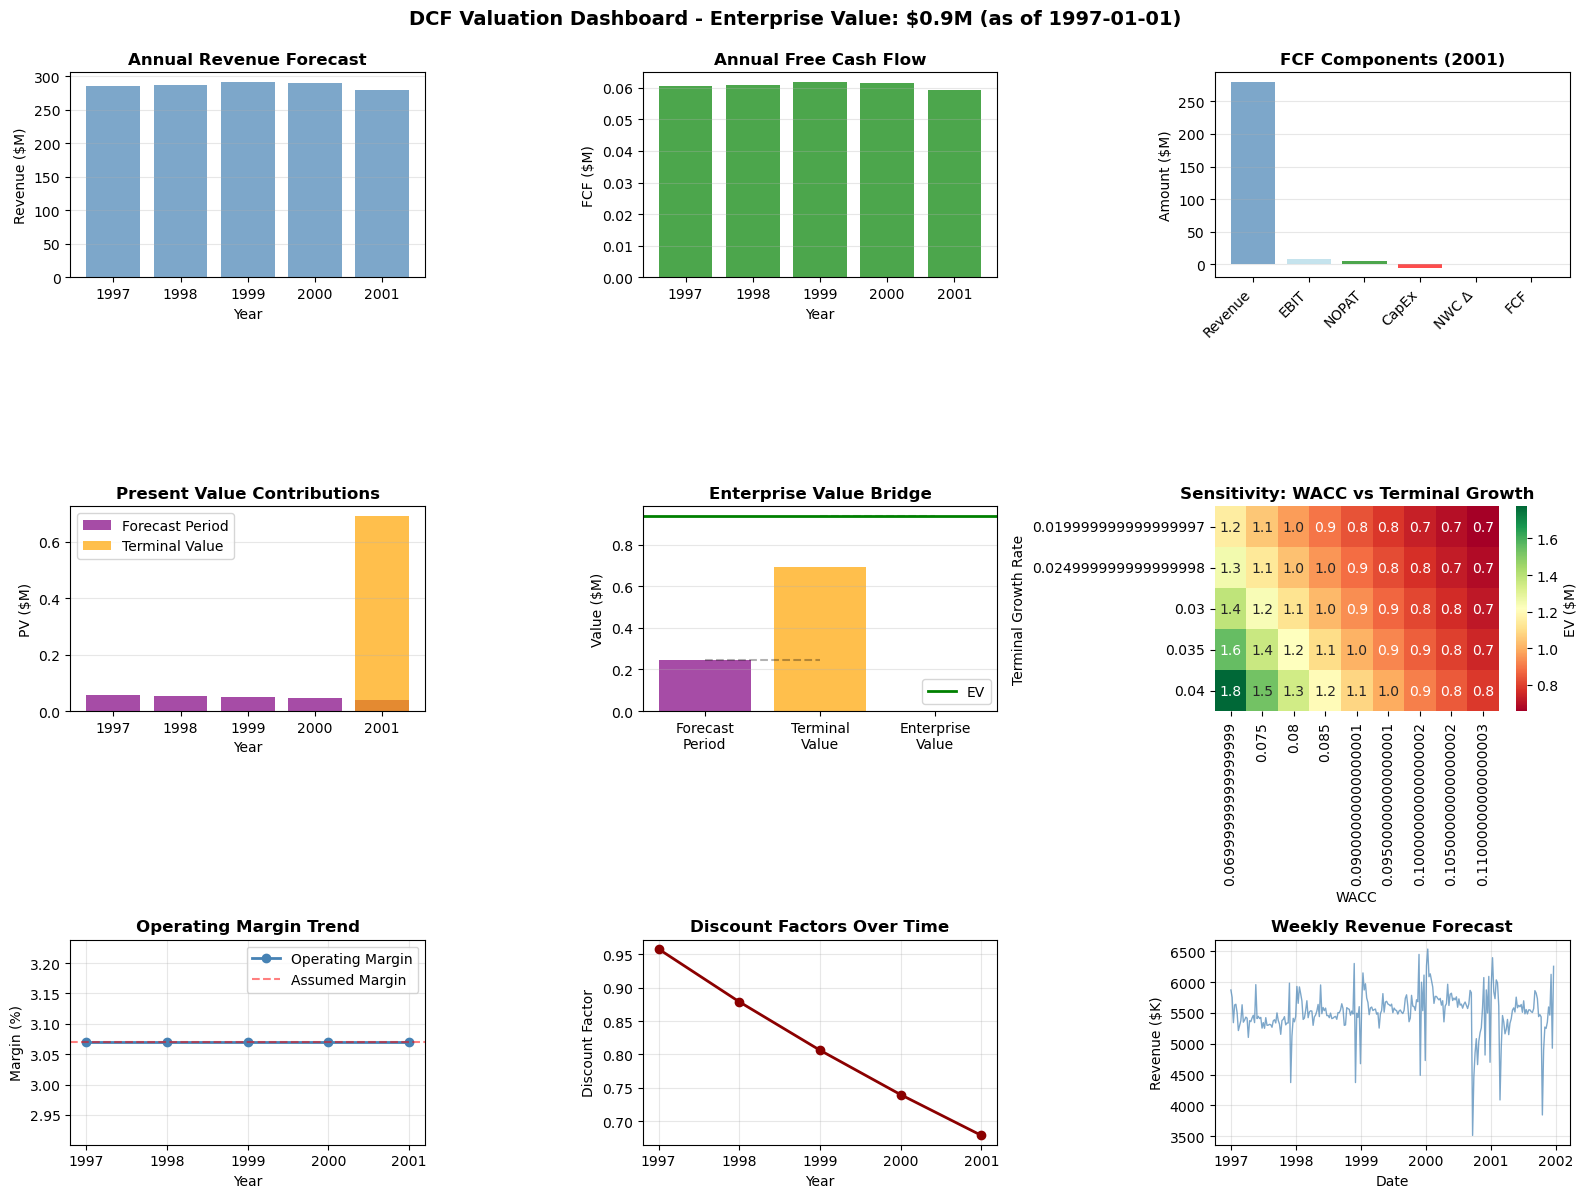

In [12]:
if dcf:
    dcf.create_visualizations()

### Step 9: Export Results

This method saves the key data tables (annual model, sensitivity, and summary) to `.csv` files.

In [13]:
if dcf:
    dcf.export_results()

EXPORTING RESULTS
DCF model saved to: report/dcf_model_annual.csv
Sensitivity analysis saved to: report/dcf_sensitivity_analysis.csv
Summary report saved to: report/dcf_valuation_summary.csv


## Conclusion

The valuation is complete. We have successfully worked around the data-class incompatibility by manually aggregating the forecasts. We then used the `ValuationDCF` class to apply financial assumptions and generate a full DCF model with sensitivity analysis and visualizations. 

Check your directory for the output files:

- `dcf_valuation_dashboard.png`
- `dcf_model_annual.csv`
- `dcf_sensitivity_analysis.csv`
- `dcf_valuation_summary.csv`